In [1]:
from pathlib import Path
from pytorch_lightning import Trainer
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint #GpuUsageLogger
from src.settings import RESULT_DIR
from src.conf.config import CONFIG
from src.dl.lightning_model import SegModel
from src.dl.model_builder import ModelBuilder
from src.dl.loss_builder import LossBuilder

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/home/leos/.local/lib/python3.6/site-packages/torchvision/extension.py:11: ResourceWarning:

unclosed file <_io.BufferedReader name='/home/leos/.local/lib/python3.6/site-packages/torchvision/_C.so'>

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package

# Train a pytorch model

- Any model should work if it's wrapped to lightning SegModel wrapper. e.g. smp models

In [2]:
# get the config file
config = CONFIG

# Set the model to do instance or panoptic segmentation (depends what's in the config.py file)
base_model = ModelBuilder.set_model("Unet", config)

# Insert the model to pytorch lightning framework. (Simplifies the training and other stuff)
lightning_model = SegModel.from_conf(base_model, config)

In [3]:
tt_logger = pl_loggers.TestTubeLogger(
    save_dir=RESULT_DIR,
    name=config.experiment_args.model_name,
    version=config.experiment_args.experiment_version
)

checkpoint_dir = (
    Path(tt_logger.save_dir)
    / tt_logger.experiment.name
    / f"version_{tt_logger.experiment.version}"
)

checkpoint_callback = ModelCheckpoint(
    filepath = str(checkpoint_dir),
    save_top_k = 1,
    save_last = True,
    verbose = True, 
    monitor = 'avg_val_loss',
    mode = 'min',
    prefix = ''
)

if config.training_args.resume_training:   
    last_checkpoint_path = lightning_model.fm.model_checkpoint("last")
    trainer = Trainer(
        default_root_dir=config.experiment_args.experiment_root_dir,
        max_epochs=config.training_args.num_epochs, 
        gpus=config.training_args.num_gpus,  
        logger=tt_logger,
        checkpoint_callback=checkpoint_callback,
        #callbacks=[GPUStatsMonitor()],
        resume_from_checkpoint=str(last_checkpoint_path),
        profiler=True,
    )
    
else:
    trainer = Trainer(
        default_root_dir=config.experiment_args.experiment_root_dir,
        max_epochs=config.training_args.num_epochs, 
        gpus=config.training_args.num_gpus,  
        logger=tt_logger,
        checkpoint_callback=checkpoint_callback,
        # callbacks=[GpuUsageLogger()],
        profiler=True,
    )
    

# find the batch size automatically
# new_batch_size = trainer.scale_batch_size(lightning_model)

# Override old batch size
# lightning_model.batch_size = new_batch_size

/home/leos/.local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning:

Checkpoint directory /home/local/leos/Dippa/results/tests/UNET/version_panoptic_hover_testtt exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [4]:
log_dir = (
    Path(tt_logger.save_dir)
    / tt_logger.experiment.name
    / f"version_{tt_logger.experiment.version}"
    / "tf"
)

In [5]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

# Train the model

In [6]:
trainer.fit(lightning_model)

/home/leos/.local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning:

Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given


  | Name      | Type                  | Params
----------------------------------------------------
0 | model     | SmpModelWithClsBranch | 72 M  
1 | criterion | JointPanopticLoss     | 0     
Epoch 30:  95%|█████████▌| 571/599 [04:46<00:14,  1.99it/s, loss=0.402, v_num=sttt]
Validating: 0it [00:00, ?it/s]
Epoch 30: 100%|██████████| 599/599 [05:01<00:00,  1.99it/s, loss=0.402, v_num=sttt]
Epoch 00030: avg_val_loss reached 0.85691 (best 0.85691), saving model to /home/local/leos/Dippa/results/tests/UNET/version_panoptic_hover_testtt/epoch=30.ckpt as top 1
Epoch 31:  95%|█████████▌| 571/599 [04:49<00:14,  1.97it/s, loss=0.395, v_num=sttt]
Validating: 0it [00:00, ?it/s]
Epoch 31: 100%|██████████| 599/599 [05:03<00:00,  1.97it/s, loss=0.395, v_num=sttt]
Epoch 

1

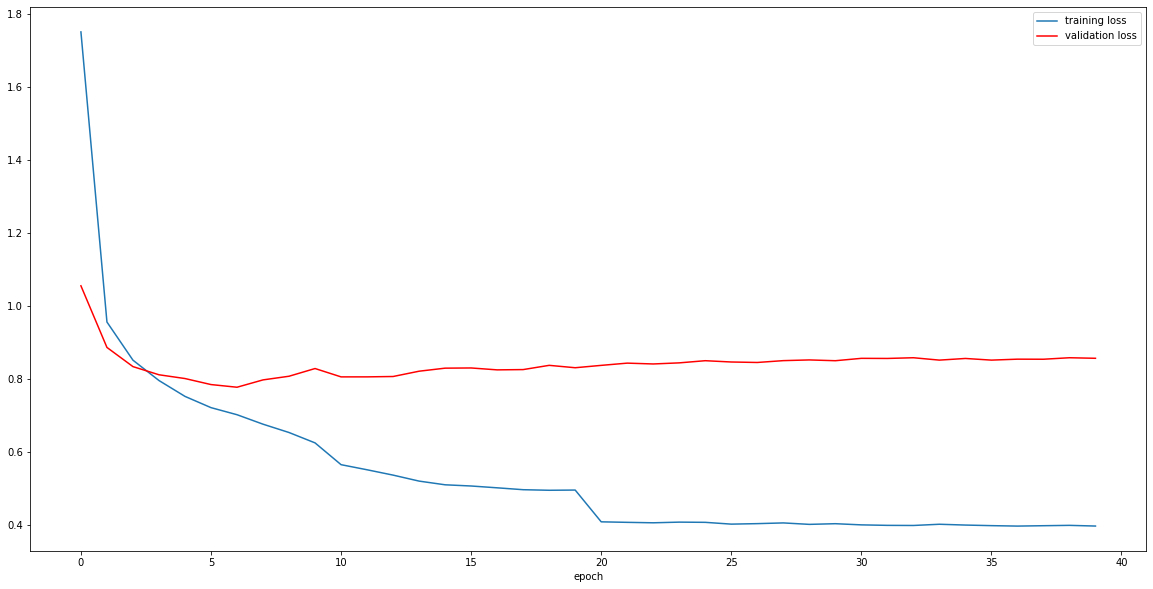

In [9]:
lightning_model.plot_metrics(metric="loss", scale='linear', save=False)

In [8]:
trainer.test(
    model=lightning_model,
    ckpt_path=lightning_model.fm.model_checkpoint("last").as_posix()
)

/home/leos/.local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning:

Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given

/home/leos/.local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning:

You're resuming from a checkpoint that ended mid-epoch. This can cause unreliable results if further training is done, consider using an end of epoch checkpoint. 

Testing: 100%|██████████| 28/28 [00:16<00:00,  4.12it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy': tensor(0.9358, device='cuda:0'),
 'avg_test_iou': tensor(0.6258, device='cuda:0'),
 'avg_test_loss': tensor(0.8571, device='cuda:0'),
 'loss': tensor(0.8571, device='cuda:0')}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 28/28 [00:16<00:00,  1.71it/s

[{'avg_test_loss': 0.8570650815963745,
  'avg_test_accuracy': 0.9358461499214172,
  'avg_test_iou': 0.6257708668708801,
  'loss': 0.8570650815963745}]